# a ) imports and data

In [14]:
import torch
import torch.nn.functional as f
import matplotlib.pyplot as plt
from collections import OrderedDict

from torch import nn
from torch import tensor
import torch.optim as optim
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor,transforms
from torch.utils.data import DataLoader

import numpy as np


In [15]:
from vit import visionTransformer
from my_utils.Trainer_module import Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
# prepare data
test_transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
                                )




train_transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                # transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=8,), # DID NOT WORK
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
                                )

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)



big_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
# train_val split
trainset, valset = torch.utils.data.random_split(big_trainset, [45000, 5000])






Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


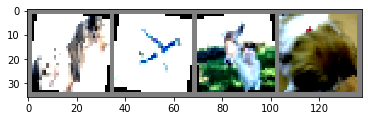

In [17]:
# show some images from valset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2))
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))


In [18]:
# # dummy trainset for testing
# trainset = torch.utils.data.Subset(trainset, range(500))
# valset = torch.utils.data.Subset(valset, range(50))

In [19]:
# check label 
image,label = trainset[5]
print(label)

5


# b) exp1



In [34]:
# CONTROL PANEL ------------------------------------------------

DROUP_OUT = 0.65
WEIGHT_DECAY = 5e-4
LR = 1e-3
LOAD_MODEL = 'exp_1_v10.pth'

name = 'exp_1_v18'

In [51]:
model = visionTransformer(token_dim=48,
                          patch_size=4,
                          image_size=32,
                          n_attention_layers=4,
                          multihead_attention_head_dim=48,
                          multihead_attention_n_heads=8,
                          multilayer_perceptron_hidden_dim=512,
                          dropout_p= DROUP_OUT,
                          n_classes=10) #.to(device)


# He intialization
for m in model.modules():
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
        

In [47]:
# for dataparallelism
model = nn.DataParallel(model)
model = model.to(device)


In [48]:
#optimizer and loss function

optimizer =optim.Adam(model.parameters(),lr = LR ,weight_decay = WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss() 

trainer = Trainer(model,optimizer,criterion,trainset,valset,testset,device,batch_size=128)

In [49]:
# # callback to check how model weights are changing
# class get_l2_norm:
#     def __init__(self):
#         self.log = list()
#     def __call__(self,model):
#         l2_norm = 0
#         for param in model.parameters():
#             l2_norm += torch.norm(param)
#         self.log.append( l2_norm.detach().cpu().numpy() )

# l2_norm_callback = get_l2_norm()



In [50]:
#load model 
trainer.load_model(filename= LOAD_MODEL)

# test the model
print( trainer.test() )




{'test_loss': [0.0064938489854335785], 'test_acc': [0.7215]}


epoch: 0, train_loss: 0.007, train_acc: 0.698
epoch: 0, val_loss: 0.007, val_acc: 0.687
epoch: 1, train_loss: 0.006, train_acc: 0.707
epoch: 1, val_loss: 0.007, val_acc: 0.674
epoch: 2, train_loss: 0.006, train_acc: 0.712
epoch: 2, val_loss: 0.007, val_acc: 0.679
epoch: 3, train_loss: 0.006, train_acc: 0.718
epoch: 3, val_loss: 0.007, val_acc: 0.687
epoch: 4, train_loss: 0.006, train_acc: 0.720
epoch: 4, val_loss: 0.007, val_acc: 0.694


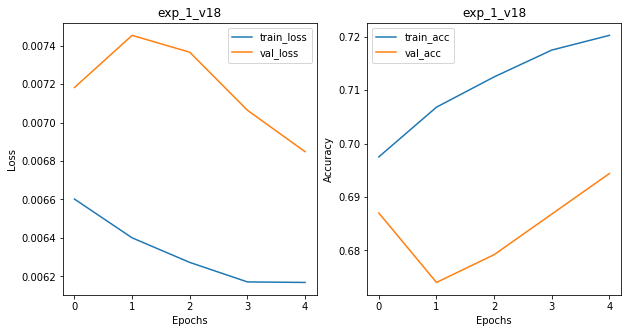

In [77]:
# trainer.valset = testset
# train the modeL
# trainer.train(5,callbacks= [l2_norm_callback])

trainer.train(5)


# trainer.plot( save_path="plots/b/", filename="exp_1_v4.png",title = "exp_1_v4")
trainer.plot( save_path="plots/b/",log_path= "logs/b/" ,filename=name+".png",title = name)

# save model 
# trainer.save_model( save_path='model_zoo/', filename='exp_1_v3.pth')
trainer.save_model( save_path='model_zoo/', filename=name+'.pth')

# del model


# c) patch sizes

In [21]:
# CONTROL PANEL ------------------------------------------------

DROUP_OUT = 0.65
WEIGHT_DECAY = 5e-4
LR = 1e-3
BATCH_SIZE = 128
# LOAD_MODEL = 'exp_1_v15.pth'

# NAME = 'exp_1_v17'

epoch: 0, train_loss: 0.062, train_acc: 0.271
epoch: 0, val_loss: 0.057, val_acc: 0.353
epoch: 1, train_loss: 0.050, train_acc: 0.419
epoch: 1, val_loss: 0.048, val_acc: 0.434
epoch: 2, train_loss: 0.045, train_acc: 0.478
epoch: 2, val_loss: 0.043, val_acc: 0.499
epoch: 3, train_loss: 0.042, train_acc: 0.511
epoch: 3, val_loss: 0.042, val_acc: 0.521
epoch: 4, train_loss: 0.040, train_acc: 0.533
epoch: 4, val_loss: 0.039, val_acc: 0.553
epoch: 5, train_loss: 0.039, train_acc: 0.552
epoch: 5, val_loss: 0.039, val_acc: 0.558
epoch: 6, train_loss: 0.037, train_acc: 0.568
epoch: 6, val_loss: 0.038, val_acc: 0.562
epoch: 7, train_loss: 0.037, train_acc: 0.576
epoch: 7, val_loss: 0.037, val_acc: 0.564
epoch: 8, train_loss: 0.036, train_acc: 0.588
epoch: 8, val_loss: 0.036, val_acc: 0.591
epoch: 9, train_loss: 0.035, train_acc: 0.602
epoch: 9, val_loss: 0.035, val_acc: 0.596
epoch: 10, train_loss: 0.034, train_acc: 0.613
epoch: 10, val_loss: 0.035, val_acc: 0.595
epoch: 11, train_loss: 0.033, 

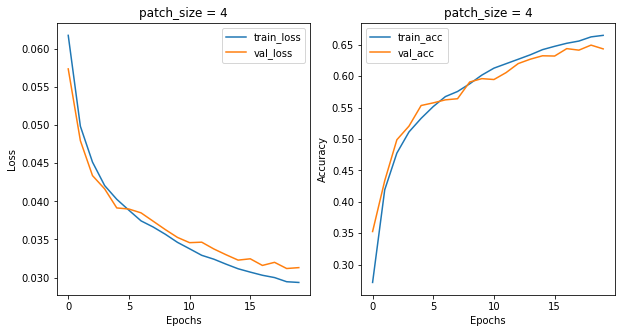

epoch: 0, train_loss: 0.061, train_acc: 0.293
epoch: 0, val_loss: 0.054, val_acc: 0.382
epoch: 1, train_loss: 0.050, train_acc: 0.425
epoch: 1, val_loss: 0.048, val_acc: 0.450
epoch: 2, train_loss: 0.046, train_acc: 0.470
epoch: 2, val_loss: 0.045, val_acc: 0.486
epoch: 3, train_loss: 0.043, train_acc: 0.499
epoch: 3, val_loss: 0.043, val_acc: 0.510
epoch: 4, train_loss: 0.042, train_acc: 0.518
epoch: 4, val_loss: 0.042, val_acc: 0.529
epoch: 5, train_loss: 0.041, train_acc: 0.532
epoch: 5, val_loss: 0.042, val_acc: 0.524
epoch: 6, train_loss: 0.040, train_acc: 0.542
epoch: 6, val_loss: 0.041, val_acc: 0.529
epoch: 7, train_loss: 0.039, train_acc: 0.550
epoch: 7, val_loss: 0.040, val_acc: 0.537
epoch: 8, train_loss: 0.038, train_acc: 0.558
epoch: 8, val_loss: 0.040, val_acc: 0.548
epoch: 9, train_loss: 0.038, train_acc: 0.567
epoch: 9, val_loss: 0.039, val_acc: 0.564
epoch: 10, train_loss: 0.037, train_acc: 0.573
epoch: 10, val_loss: 0.039, val_acc: 0.566
epoch: 11, train_loss: 0.037, 

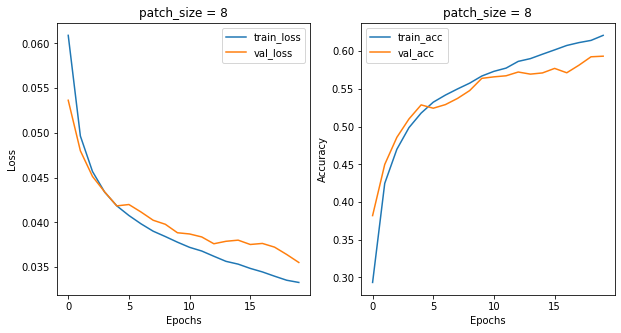

epoch: 0, train_loss: 0.060, train_acc: 0.303
epoch: 0, val_loss: 0.053, val_acc: 0.387
epoch: 1, train_loss: 0.051, train_acc: 0.420
epoch: 1, val_loss: 0.049, val_acc: 0.430
epoch: 2, train_loss: 0.048, train_acc: 0.453
epoch: 2, val_loss: 0.047, val_acc: 0.461
epoch: 3, train_loss: 0.046, train_acc: 0.471
epoch: 3, val_loss: 0.046, val_acc: 0.479
epoch: 4, train_loss: 0.045, train_acc: 0.482
epoch: 4, val_loss: 0.045, val_acc: 0.478
epoch: 5, train_loss: 0.044, train_acc: 0.493
epoch: 5, val_loss: 0.045, val_acc: 0.489
epoch: 6, train_loss: 0.043, train_acc: 0.502
epoch: 6, val_loss: 0.044, val_acc: 0.502
epoch: 7, train_loss: 0.043, train_acc: 0.506
epoch: 7, val_loss: 0.045, val_acc: 0.487
epoch: 8, train_loss: 0.042, train_acc: 0.514
epoch: 8, val_loss: 0.044, val_acc: 0.503
epoch: 9, train_loss: 0.042, train_acc: 0.519
epoch: 9, val_loss: 0.043, val_acc: 0.510
epoch: 10, train_loss: 0.042, train_acc: 0.522
epoch: 10, val_loss: 0.043, val_acc: 0.505
epoch: 11, train_loss: 0.041, 

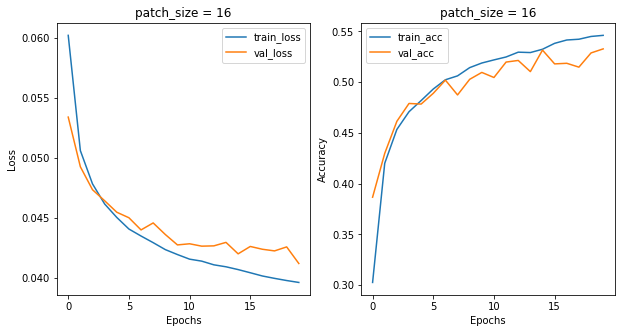

In [82]:
""" 
c) [Experiment 2] Try out different patch sizes (like 4x4, 8x8, 16x16). You
can divide the image into both overlapping and non-overlapping
patches.
""" 

for patch_size in [4,8,16]:
    model = visionTransformer(token_dim=48,
                              patch_size=patch_size,
                              image_size=32,
                              n_attention_layers=4,
                              multihead_attention_head_dim=48,
                              multihead_attention_n_heads=8,
                              multilayer_perceptron_hidden_dim=512,
                              dropout_p= DROUP_OUT,
                              n_classes=10).to(device)

    #optimizer and loss function
    optimizer =optim.Adam(model.parameters(),lr = LR ,weight_decay = WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()

    trainer = Trainer(model,optimizer,criterion,trainset,valset,testset,device,batch_size=BATCH_SIZE)
    trainer.train(20)
    trainer.plot( title="patch_size = {}".format(patch_size), save_path="plots/c/", filename="exp_2_patch_size_{}.png".format(patch_size),log_path= "logs/b/" )
    trainer.save_model( save_path='model_zoo/', filename= f"exp_2_patch_size_{patch_size}" + '.pth')



epoch: 0, train_loss: 0.016, train_acc: 0.250
epoch: 0, val_loss: 0.015, val_acc: 0.350
epoch: 1, train_loss: 0.013, train_acc: 0.413
epoch: 1, val_loss: 0.012, val_acc: 0.457
epoch: 2, train_loss: 0.011, train_acc: 0.485
epoch: 2, val_loss: 0.011, val_acc: 0.510
epoch: 3, train_loss: 0.010, train_acc: 0.529
epoch: 3, val_loss: 0.011, val_acc: 0.508
epoch: 4, train_loss: 0.010, train_acc: 0.555
epoch: 4, val_loss: 0.010, val_acc: 0.550
epoch: 5, train_loss: 0.009, train_acc: 0.573
epoch: 5, val_loss: 0.009, val_acc: 0.579
epoch: 6, train_loss: 0.009, train_acc: 0.590
epoch: 6, val_loss: 0.010, val_acc: 0.573
epoch: 7, train_loss: 0.009, train_acc: 0.601
epoch: 7, val_loss: 0.009, val_acc: 0.605
epoch: 8, train_loss: 0.008, train_acc: 0.617
epoch: 8, val_loss: 0.009, val_acc: 0.610
epoch: 9, train_loss: 0.008, train_acc: 0.626
epoch: 9, val_loss: 0.009, val_acc: 0.623
epoch: 10, train_loss: 0.008, train_acc: 0.636
epoch: 10, val_loss: 0.009, val_acc: 0.618
epoch: 11, train_loss: 0.008, 

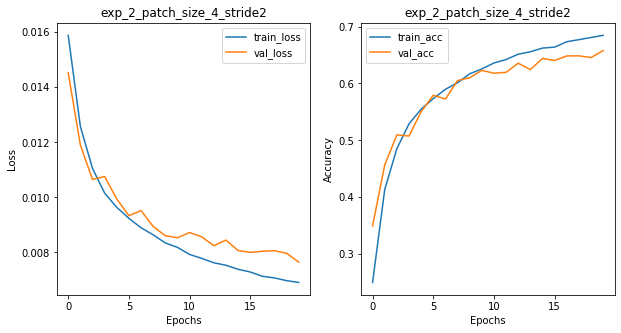

epoch: 0, train_loss: 0.016, train_acc: 0.268
epoch: 0, val_loss: 0.015, val_acc: 0.351
epoch: 1, train_loss: 0.013, train_acc: 0.419
epoch: 1, val_loss: 0.012, val_acc: 0.444
epoch: 2, train_loss: 0.011, train_acc: 0.469
epoch: 2, val_loss: 0.011, val_acc: 0.490
epoch: 3, train_loss: 0.011, train_acc: 0.503
epoch: 3, val_loss: 0.011, val_acc: 0.510
epoch: 4, train_loss: 0.010, train_acc: 0.525
epoch: 4, val_loss: 0.010, val_acc: 0.536
epoch: 5, train_loss: 0.010, train_acc: 0.543
epoch: 5, val_loss: 0.010, val_acc: 0.543
epoch: 6, train_loss: 0.010, train_acc: 0.561
epoch: 6, val_loss: 0.010, val_acc: 0.559
epoch: 7, train_loss: 0.009, train_acc: 0.570
epoch: 7, val_loss: 0.010, val_acc: 0.571
epoch: 8, train_loss: 0.009, train_acc: 0.581
epoch: 8, val_loss: 0.010, val_acc: 0.562
epoch: 9, train_loss: 0.009, train_acc: 0.592
epoch: 9, val_loss: 0.009, val_acc: 0.576
epoch: 10, train_loss: 0.009, train_acc: 0.602
epoch: 10, val_loss: 0.009, val_acc: 0.581
epoch: 11, train_loss: 0.009, 

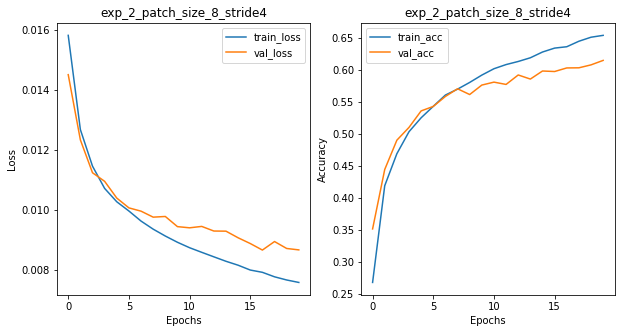

epoch: 0, train_loss: 0.016, train_acc: 0.278
epoch: 0, val_loss: 0.014, val_acc: 0.369
epoch: 1, train_loss: 0.013, train_acc: 0.409
epoch: 1, val_loss: 0.013, val_acc: 0.433
epoch: 2, train_loss: 0.012, train_acc: 0.454
epoch: 2, val_loss: 0.012, val_acc: 0.466
epoch: 3, train_loss: 0.011, train_acc: 0.478
epoch: 3, val_loss: 0.011, val_acc: 0.492
epoch: 4, train_loss: 0.011, train_acc: 0.497
epoch: 4, val_loss: 0.011, val_acc: 0.505
epoch: 5, train_loss: 0.011, train_acc: 0.510
epoch: 5, val_loss: 0.011, val_acc: 0.496
epoch: 6, train_loss: 0.010, train_acc: 0.520
epoch: 6, val_loss: 0.011, val_acc: 0.515
epoch: 7, train_loss: 0.010, train_acc: 0.529
epoch: 7, val_loss: 0.011, val_acc: 0.518
epoch: 8, train_loss: 0.010, train_acc: 0.537
epoch: 8, val_loss: 0.011, val_acc: 0.528
epoch: 9, train_loss: 0.010, train_acc: 0.547
epoch: 9, val_loss: 0.010, val_acc: 0.538
epoch: 10, train_loss: 0.010, train_acc: 0.551
epoch: 10, val_loss: 0.011, val_acc: 0.537
epoch: 11, train_loss: 0.010, 

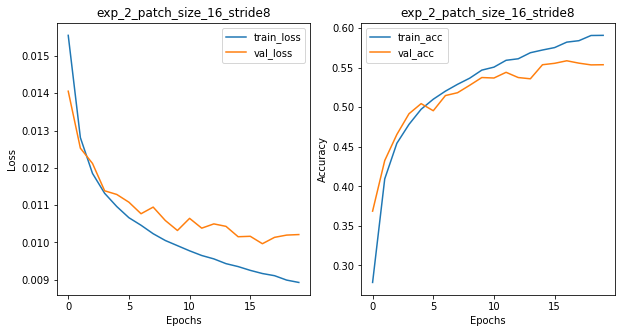

epoch: 0, train_loss: 0.016, train_acc: 0.256
epoch: 0, val_loss: 0.015, val_acc: 0.354
epoch: 1, train_loss: 0.013, train_acc: 0.409
epoch: 1, val_loss: 0.012, val_acc: 0.441
epoch: 2, train_loss: 0.011, train_acc: 0.474
epoch: 2, val_loss: 0.011, val_acc: 0.495
epoch: 3, train_loss: 0.010, train_acc: 0.521
epoch: 3, val_loss: 0.010, val_acc: 0.529
epoch: 4, train_loss: 0.010, train_acc: 0.548
epoch: 4, val_loss: 0.010, val_acc: 0.553
epoch: 5, train_loss: 0.009, train_acc: 0.570
epoch: 5, val_loss: 0.010, val_acc: 0.572
epoch: 6, train_loss: 0.009, train_acc: 0.585
epoch: 6, val_loss: 0.009, val_acc: 0.584
epoch: 7, train_loss: 0.009, train_acc: 0.603
epoch: 7, val_loss: 0.009, val_acc: 0.599
epoch: 8, train_loss: 0.008, train_acc: 0.616
epoch: 8, val_loss: 0.009, val_acc: 0.611
epoch: 9, train_loss: 0.008, train_acc: 0.629
epoch: 9, val_loss: 0.009, val_acc: 0.623
epoch: 10, train_loss: 0.008, train_acc: 0.635
epoch: 10, val_loss: 0.009, val_acc: 0.612
epoch: 11, train_loss: 0.008, 

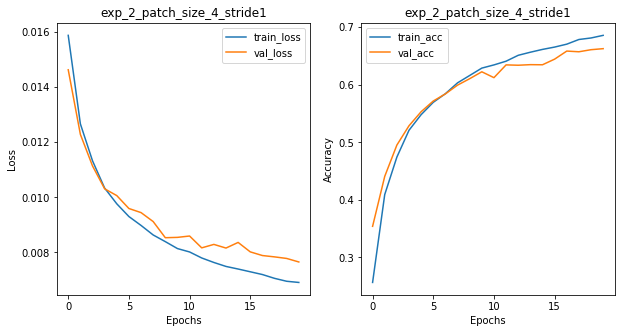

epoch: 0, train_loss: 0.016, train_acc: 0.262
epoch: 0, val_loss: 0.014, val_acc: 0.363
epoch: 1, train_loss: 0.013, train_acc: 0.414
epoch: 1, val_loss: 0.012, val_acc: 0.452
epoch: 2, train_loss: 0.011, train_acc: 0.476
epoch: 2, val_loss: 0.011, val_acc: 0.500
epoch: 3, train_loss: 0.011, train_acc: 0.509
epoch: 3, val_loss: 0.011, val_acc: 0.516
epoch: 4, train_loss: 0.010, train_acc: 0.527
epoch: 4, val_loss: 0.011, val_acc: 0.523
epoch: 5, train_loss: 0.010, train_acc: 0.546
epoch: 5, val_loss: 0.010, val_acc: 0.540
epoch: 6, train_loss: 0.010, train_acc: 0.556
epoch: 6, val_loss: 0.010, val_acc: 0.547
epoch: 7, train_loss: 0.009, train_acc: 0.569
epoch: 7, val_loss: 0.010, val_acc: 0.559
epoch: 8, train_loss: 0.009, train_acc: 0.581
epoch: 8, val_loss: 0.010, val_acc: 0.571
epoch: 9, train_loss: 0.009, train_acc: 0.588
epoch: 9, val_loss: 0.010, val_acc: 0.572
epoch: 10, train_loss: 0.009, train_acc: 0.595
epoch: 10, val_loss: 0.010, val_acc: 0.573
epoch: 11, train_loss: 0.009, 

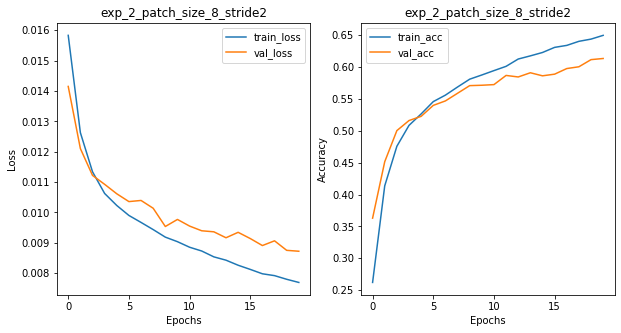

epoch: 0, train_loss: 0.016, train_acc: 0.277
epoch: 0, val_loss: 0.014, val_acc: 0.373
epoch: 1, train_loss: 0.013, train_acc: 0.406
epoch: 1, val_loss: 0.013, val_acc: 0.430
epoch: 2, train_loss: 0.012, train_acc: 0.449
epoch: 2, val_loss: 0.012, val_acc: 0.468
epoch: 3, train_loss: 0.011, train_acc: 0.475
epoch: 3, val_loss: 0.011, val_acc: 0.483
epoch: 4, train_loss: 0.011, train_acc: 0.494
epoch: 4, val_loss: 0.011, val_acc: 0.502
epoch: 5, train_loss: 0.011, train_acc: 0.504
epoch: 5, val_loss: 0.011, val_acc: 0.501
epoch: 6, train_loss: 0.011, train_acc: 0.516
epoch: 6, val_loss: 0.011, val_acc: 0.508
epoch: 7, train_loss: 0.010, train_acc: 0.528
epoch: 7, val_loss: 0.011, val_acc: 0.513
epoch: 8, train_loss: 0.010, train_acc: 0.531
epoch: 8, val_loss: 0.011, val_acc: 0.540
epoch: 9, train_loss: 0.010, train_acc: 0.543
epoch: 9, val_loss: 0.010, val_acc: 0.533
epoch: 10, train_loss: 0.010, train_acc: 0.545
epoch: 10, val_loss: 0.011, val_acc: 0.529
epoch: 11, train_loss: 0.010, 

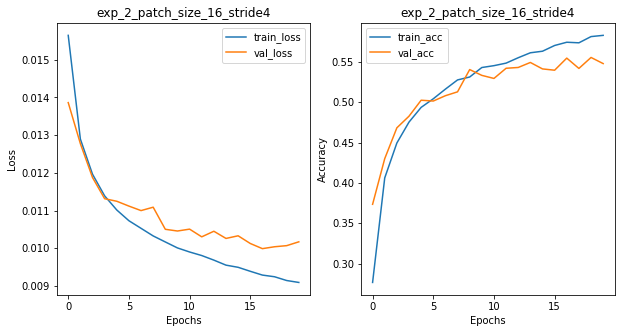

In [87]:
# with overlapping patches
#----------------------------------------------------------------------------------------

for OVERLAP in [2,4]:
    for patch_size in [4,8,16]:
        STRIDE = patch_size//OVERLAP
        
        # with 1/2 stride
        model = visionTransformer(token_dim=48,
                                patch_size=patch_size,
                                image_size=32,
                                n_attention_layers=4,
                                multihead_attention_head_dim=48,
                                multihead_attention_n_heads=8,
                                multilayer_perceptron_hidden_dim=512,
                                dropout_p= DROUP_OUT,
                                n_classes=10,
                                stride_in_tokenization = STRIDE            #for overlapping patches
                                ).to(device)


        #optimizer and loss function
        optimizer =optim.Adam(model.parameters(),lr=LR,weight_decay=WEIGHT_DECAY)
        criterion = nn.CrossEntropyLoss()

        trainer = Trainer(model,optimizer,criterion,trainset,valset,testset,batch_size = BATCH_SIZE)
        trainer.train(20)

        # ------------------ plot and save model ------------------
        NAME = f"exp_2_patch_size_{patch_size}_stride{STRIDE}"

        trainer.plot( title=NAME,
                            save_path="plots/c/",
                            filename=NAME + '.png',
                            log_path= "logs/c/" )


        trainer.save_model( save_path='model_zoo/', 
                            filename= NAME + '.pth')


# d) number of attention heads

epoch: 0, train_loss: 0.016, train_acc: 0.243
epoch: 0, val_loss: 0.015, val_acc: 0.334
epoch: 1, train_loss: 0.013, train_acc: 0.383
epoch: 1, val_loss: 0.013, val_acc: 0.416
epoch: 2, train_loss: 0.012, train_acc: 0.449
epoch: 2, val_loss: 0.011, val_acc: 0.473
epoch: 3, train_loss: 0.011, train_acc: 0.492
epoch: 3, val_loss: 0.011, val_acc: 0.509
epoch: 4, train_loss: 0.010, train_acc: 0.522
epoch: 4, val_loss: 0.011, val_acc: 0.520
epoch: 5, train_loss: 0.010, train_acc: 0.540
epoch: 5, val_loss: 0.010, val_acc: 0.528
epoch: 6, train_loss: 0.010, train_acc: 0.556
epoch: 6, val_loss: 0.010, val_acc: 0.545
epoch: 7, train_loss: 0.009, train_acc: 0.576
epoch: 7, val_loss: 0.009, val_acc: 0.579
epoch: 8, train_loss: 0.009, train_acc: 0.585
epoch: 8, val_loss: 0.009, val_acc: 0.588
epoch: 9, train_loss: 0.009, train_acc: 0.598
epoch: 9, val_loss: 0.009, val_acc: 0.588
epoch: 10, train_loss: 0.009, train_acc: 0.608
epoch: 10, val_loss: 0.009, val_acc: 0.602
epoch: 11, train_loss: 0.008, 

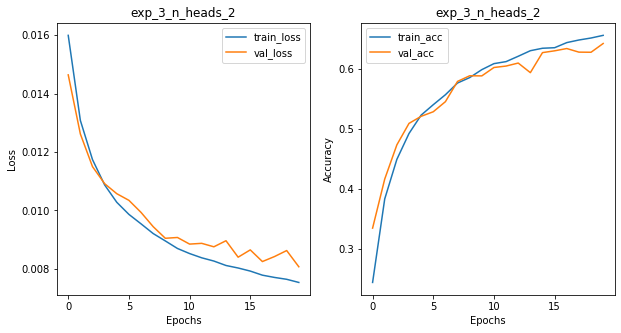

epoch: 0, train_loss: 0.016, train_acc: 0.250
epoch: 0, val_loss: 0.015, val_acc: 0.334
epoch: 1, train_loss: 0.013, train_acc: 0.402
epoch: 1, val_loss: 0.013, val_acc: 0.425
epoch: 2, train_loss: 0.011, train_acc: 0.479
epoch: 2, val_loss: 0.011, val_acc: 0.497
epoch: 3, train_loss: 0.010, train_acc: 0.521
epoch: 3, val_loss: 0.010, val_acc: 0.542
epoch: 4, train_loss: 0.010, train_acc: 0.547
epoch: 4, val_loss: 0.010, val_acc: 0.537
epoch: 5, train_loss: 0.009, train_acc: 0.572
epoch: 5, val_loss: 0.009, val_acc: 0.583
epoch: 6, train_loss: 0.009, train_acc: 0.587
epoch: 6, val_loss: 0.009, val_acc: 0.584
epoch: 7, train_loss: 0.009, train_acc: 0.603
epoch: 7, val_loss: 0.009, val_acc: 0.586
epoch: 8, train_loss: 0.008, train_acc: 0.618
epoch: 8, val_loss: 0.009, val_acc: 0.595
epoch: 9, train_loss: 0.008, train_acc: 0.625
epoch: 9, val_loss: 0.008, val_acc: 0.623
epoch: 10, train_loss: 0.008, train_acc: 0.633
epoch: 10, val_loss: 0.009, val_acc: 0.609
epoch: 11, train_loss: 0.008, 

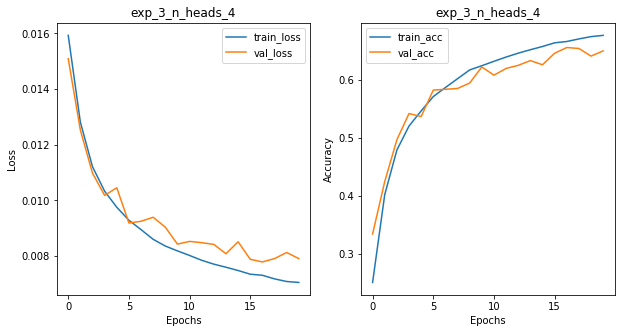

epoch: 0, train_loss: 0.016, train_acc: 0.254
epoch: 0, val_loss: 0.015, val_acc: 0.354
epoch: 1, train_loss: 0.013, train_acc: 0.413
epoch: 1, val_loss: 0.012, val_acc: 0.455
epoch: 2, train_loss: 0.011, train_acc: 0.487
epoch: 2, val_loss: 0.011, val_acc: 0.512
epoch: 3, train_loss: 0.010, train_acc: 0.526
epoch: 3, val_loss: 0.010, val_acc: 0.540
epoch: 4, train_loss: 0.010, train_acc: 0.555
epoch: 4, val_loss: 0.010, val_acc: 0.562
epoch: 5, train_loss: 0.009, train_acc: 0.577
epoch: 5, val_loss: 0.010, val_acc: 0.561
epoch: 6, train_loss: 0.009, train_acc: 0.593
epoch: 6, val_loss: 0.009, val_acc: 0.583
epoch: 7, train_loss: 0.009, train_acc: 0.606
epoch: 7, val_loss: 0.009, val_acc: 0.600
epoch: 8, train_loss: 0.008, train_acc: 0.619
epoch: 8, val_loss: 0.009, val_acc: 0.610
epoch: 9, train_loss: 0.008, train_acc: 0.631
epoch: 9, val_loss: 0.009, val_acc: 0.606
epoch: 10, train_loss: 0.008, train_acc: 0.642
epoch: 10, val_loss: 0.008, val_acc: 0.624
epoch: 11, train_loss: 0.008, 

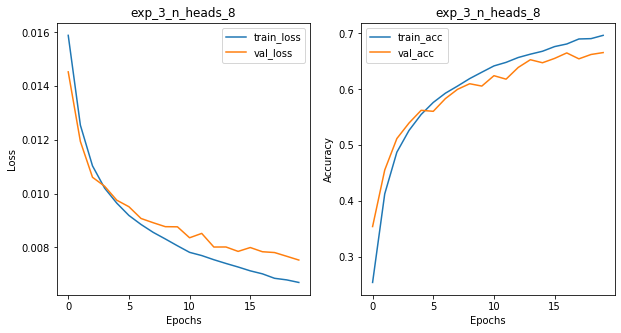

In [88]:
# with diffent number of heads 
for n_heads in [2,4,8]:
    model = visionTransformer(token_dim=48,
                              patch_size=4,
                              image_size=32,
                              n_attention_layers=4,
                              multihead_attention_head_dim=48,
                              multihead_attention_n_heads=n_heads,                  # for different number of heads
                              multilayer_perceptron_hidden_dim=512,
                              dropout_p= DROUP_OUT,
                              n_classes=10).to(device)

    #optimizer and loss function
    optimizer =optim.Adam(model.parameters(),lr = LR ,weight_decay = WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()

    trainer = Trainer(model,optimizer,criterion,trainset,valset,testset,device,batch_size=BATCH_SIZE)
    trainer.train(20)
    # trainer.plot( title="n_heads = {}".format(n_heads), save_path="plots/d/", filename="exp_3_n_heads_{}.png".format(n_heads))
    

    # ------------------ plot and save model ------------------
    # NAME = f"exp_2_patch_size_{patch_size}_stride{STRIDE}"
    NAME = f"exp_3_n_heads_{n_heads}"

    trainer.plot( title=NAME,
                        save_path="plots/d/",
                        filename=NAME + '.png',
                        log_path= "logs/d/" )


    trainer.save_model( save_path='model_zoo/', 
                        filename= NAME + '.pth')

# e) cls from different layers


In [53]:

model = visionTransformer(token_dim=48,
                            patch_size=4,
                            image_size=32,
                            n_attention_layers=4,
                            multihead_attention_head_dim=48,
                            multihead_attention_n_heads=8,
                            multilayer_perceptron_hidden_dim=512,
                            dropout_p= DROUP_OUT,
                            n_classes=10) #.to(device)



# for dataparallelism
model = nn.DataParallel(model)
model = model.to(device)


criterion = nn.CrossEntropyLoss()

# load the model 
# model.load_state_dict(torch.load('model_zoo/exp_1_v10.pth'))

trainer = Trainer(model,optimizer,criterion,trainset,valset,testset,device,batch_size=BATCH_SIZE)

trainer.load_model(  filename='exp_1_v10.pth')



In [54]:
# test with tokens from different layers

# ------------------------------------
N_LAYERS = 4
loss_list = [0 for i in range(N_LAYERS)]
acc_list = [0 for i in range(N_LAYERS)]


test_loader = trainer.create_data_loader(testset) # using trainer from last experiment to keep the same batch size
model.eval()

for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        list_of_logits = model(images,return_cls_tokens_after_each_layer=True) #(4, torch.Size([32, 10]))
        for j,logits in enumerate(list_of_logits):
            loss_list[j] += criterion(logits, labels).item()
            acc_list[j] += (logits.argmax(dim=1) == labels).sum().item()
# devide with size of testset
loss_list = [loss/len(testset) for loss in loss_list]
acc_list = [acc/len(testset) for acc in acc_list]

        


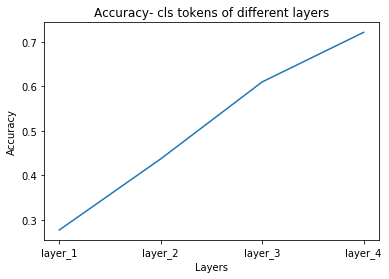

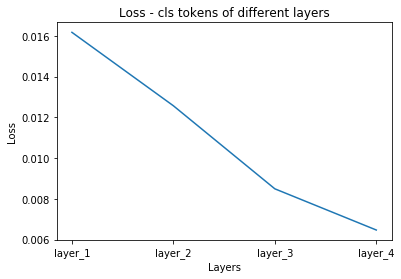

In [55]:
#bar plot using matplotlib
plt.plot(["layer_{}".format(i+1) for i in range(N_LAYERS)],acc_list)
plt.title("Accuracy- cls tokens of different layers")
plt.ylabel("Accuracy")
plt.xlabel("Layers")

# save plot
plt.savefig("plots/e/exp_4_acc.png")
plt.show()

# for loss plot
plt.plot(["layer_{}".format(i+1) for i in range(N_LAYERS)],loss_list)
plt.title("Loss - cls tokens of different layers")
plt.ylabel("Loss")
plt.xlabel("Layers")

# save plot
plt.savefig("plots/e/exp_4_loss.png")
plt.show()

In [ ]:
# final mlp is trained for final cls token. 
# so this is not fair comparison.